In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [173]:
data_train = pd.read_csv("./train.csv")
data_train.describe()

,Adj Close,Close,High,Low,Open,Volume,Target,Id
count,474171.000000,474171.000000,474171.000000,474171.000000,474171.000000,4.741550e+05,501400.000000,501400.000000
mean,68.557799,78.063775,78.793316,77.257284,78.038791,7.793082e+06,0.739250,250699.500000
std,145.555119,146.684837,148.337565,144.898091,146.575314,3.203411e+07,0.439044,144741.856823
min,0.700000,0.700000,-60.975002,0.650000,0.700000,0.000000e+00,0.000000,0.000000
25%,24.205503,30.860001,31.170000,30.530001,30.840561,9.811000e+05,0.000000,125349.750000
50%,42.509499,51.540001,52.049999,51.009998,51.529999,2.179300e+06,1.000000,250699.500000
75%,73.034061,84.540001,85.309998,83.720001,84.529999,5.196650e+06,1.000000,376049.250000
max,3892.889893,3892.889893,3946.500000,3815.500000,3900.000000,1.880998e+09,1.000000,501399.000000


In [174]:
data_test = pd.read_csv("./test.csv")
data_test.describe()


,Adj Close,Close,High,Low,Open,Volume,Id
count,207070.000000,207070.000000,207070.000000,207070.000000,207070.000000,2.070700e+05,209600.000000
mean,163.405105,166.612779,168.670907,164.489826,166.581160,5.733962e+06,104799.500000
std,378.373284,378.691237,383.331457,373.877878,378.446803,1.316767e+07,60506.452548
min,3.948789,4.020000,4.160000,3.660000,4.040000,0.000000e+00,0.000000
25%,49.376620,52.029999,52.720001,51.314999,52.009998,9.792000e+05,52399.750000
50%,95.829258,98.910004,100.180000,97.660004,98.919998,2.002450e+06,104799.500000
75%,165.751980,170.199997,172.039993,168.199997,170.119995,4.870250e+06,157199.250000
max,7687.100098,7687.100098,7712.000000,7570.100098,7612.250000,4.265100e+08,209599.000000


EKSPLORATORNA ANALIZA

1. Dimenzionalnost dataseta

In [175]:
print("Broj uzoraka")
print(data_train.shape[0])

Broj uzoraka
501400


In [176]:
print(data_train.columns)

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Target', 'Id'],
      dtype='object')


Dataset sadrži financijske podatke o dionicama, uključujući dva pomoćna atributa i šest značajki:

    Date (Datum): Datum trgovanja, koristi se kao vremenska oznaka za svaki zapis.
    Symbol (Simbol): Ime dionice, identificira kojoj kompaniji pripada svaki zapis.
    Id: Jedinstveni identifikator unutar dataseta, služi za jednoznačno identificiranje svakog zapisa.

Značajke uključene u dataset su:

    Adj Close: Prilagođena zatvarajuća cijena dionice, uzima u obzir korporativne događaje poput dividendi i podjela dionica.
    Close: Zatvarajuća cijena dionice na dan trgovanja, ne uzima u obzir naknadne promjene.
    High: Najviša cijena po kojoj se trgovalo dionicom tijekom dana.
    Low: Najniža cijena po kojoj se trgovalo dionicom tijekom dana.
    Open: Cijena dionice na otvaranju tržišta.
    Volume: Količina dionica kojima se trgovalo tijekom dana.

Oznaka za predikciju:

    Target: Ciljna oznaka koja indicira hoće li cijena dionice doživjeti najmanje 2% povećanje u sljedeća dva mjeseca. Koristi se kao osnova za predikcijske modele.

In [177]:
num_unique_stocks = data_train['Symbol'].nunique()
print("Broj jedinstvenih dionica")
print(num_unique_stocks)


Broj jedinstvenih dionica
200


2. Nedostajuće vrijednosti

Ako su sve značajke nepostojeće, radi se o danima kada ili nije bilo trgovanja određene dionice ili nemamo podatke za taj dan. U oba slučaja, zapis nam je nebitan i ne donosi nikakvu vrijednost potencijalnom modelu predikcije. Takve zapise ćemo izbaciti.

*Adj Close, Close, High, Low i Open* - nedostajuće vrijednosti možemo ubaciti korištenjem linearne interpolacije. Korištenjem linearne interpolacije sačuvat ćemo privremene trendove.

*Volume* - koristimo globalni medijan za određenu dionicu

*Date i Symbol* - ključne značajke za analizu. Ne možemo rekonstruirati podatak, tj. pravilno ga ubaciti u linearni tijek modela predikcije. Brišemo sve takve retke. (nema takvih redaka)

*Id* - Nebitan za analizu, više služi za identifikaciju unutar dataseta. Dodijelimo novi, slobodni ID (nema takvih redaka)



In [178]:
financial_features = ['Adj Close', 'Close', 'High', 'Low', 'Open']

# Prvo, izbacujemo sve redove koji nemaju ni jednu financijsku značajku
data_train.dropna(subset=financial_features, how='all', inplace=True)

# Sortiramo podatke po dionici i datumu
data_train.sort_values(by=['Symbol', 'Date'], inplace=True)

# Popunjavamo nedostajuće vrijednosti
data_train.head()

data_train[financial_features] = data_train[financial_features].interpolate(method='linear')


# za znacajku Volume koristimo globalni medijan po dionici
median_volume_by_symbol = data_train.groupby('Symbol')['Volume'].median()

for index, row in data_train.iterrows():
    if pd.isnull(row['Volume']):
        data_train.at[index, 'Volume'] = median_volume_by_symbol[row['Symbol']]

print("Broj nedostajućih vrijednosti")
print(data_train.isnull().sum())


Broj nedostajućih vrijednosti
Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Target       0
Id           0
dtype: int64


3. Duplikati

Duplikate smatramo retke u kojima su atributi *Date i Symbol* jednaki. Dva su slučaja:
1. ostale značajke su jednake: Brišemo sve retke osim jednog.
2. ostale značajke su različite: Ne možemo vjerovati podatcima, brišemo retke. Postoji opcija korištenja prosjeka po atributima, ali s obzirom da znamo da se dogodila greška (2 podatka za isti dan) postoji vjerojatnost da je došlo do pogreške u prikupljenim podatcima. Bez detaljnijeg objašnjenja kako je došlo do greške najbolje je obrisati retke.

In [179]:
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
# Uklanjanje dupliciranih zapisa gdje su 'Date' i 'Symbol' jednaki, a ostale značajke su također jednake
data_train.drop_duplicates(subset=['Date', 'Symbol'] + features, keep='first', inplace=True)

# Identificiranje i brisanje redova gdje 'Date' i 'Symbol' jednaki ali ostale značajke su različite
duplicates_with_variations = data_train[data_train.duplicated(subset=['Date', 'Symbol'], keep=False)]
duplicates_to_remove = duplicates_with_variations[duplicates_with_variations.duplicated(subset=['Date', 'Symbol'] + financial_features, keep=False) == False]

# Sada kada imamo identificirane redove koje želimo ukloniti, možemo ih izbrisati iz dataseta
data_train = data_train.drop(duplicates_to_remove.index)



4. Validacija podataka

Podatke možemo smatrati neispravnima ako je bilo koja od značajki *Adj Close, Close, High, Low, Open, Volume* negativna. Također, retke u kojima je High < Low možemo smatrati neispravnima.
Ne možemo se oporaviti od takve greške tako da sve takve retke brišemo

In [180]:
# Uklanjanje redova s negativnim vrijednostima za financijske značajke
data_train = data_train[(data_train[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] >= 0).all(axis=1)]

# Uklanjanje redova gdje je 'High' manji od 'Low'
data_train = data_train[data_train['High'] >= data_train['Low']]

5. Distribucije značajki

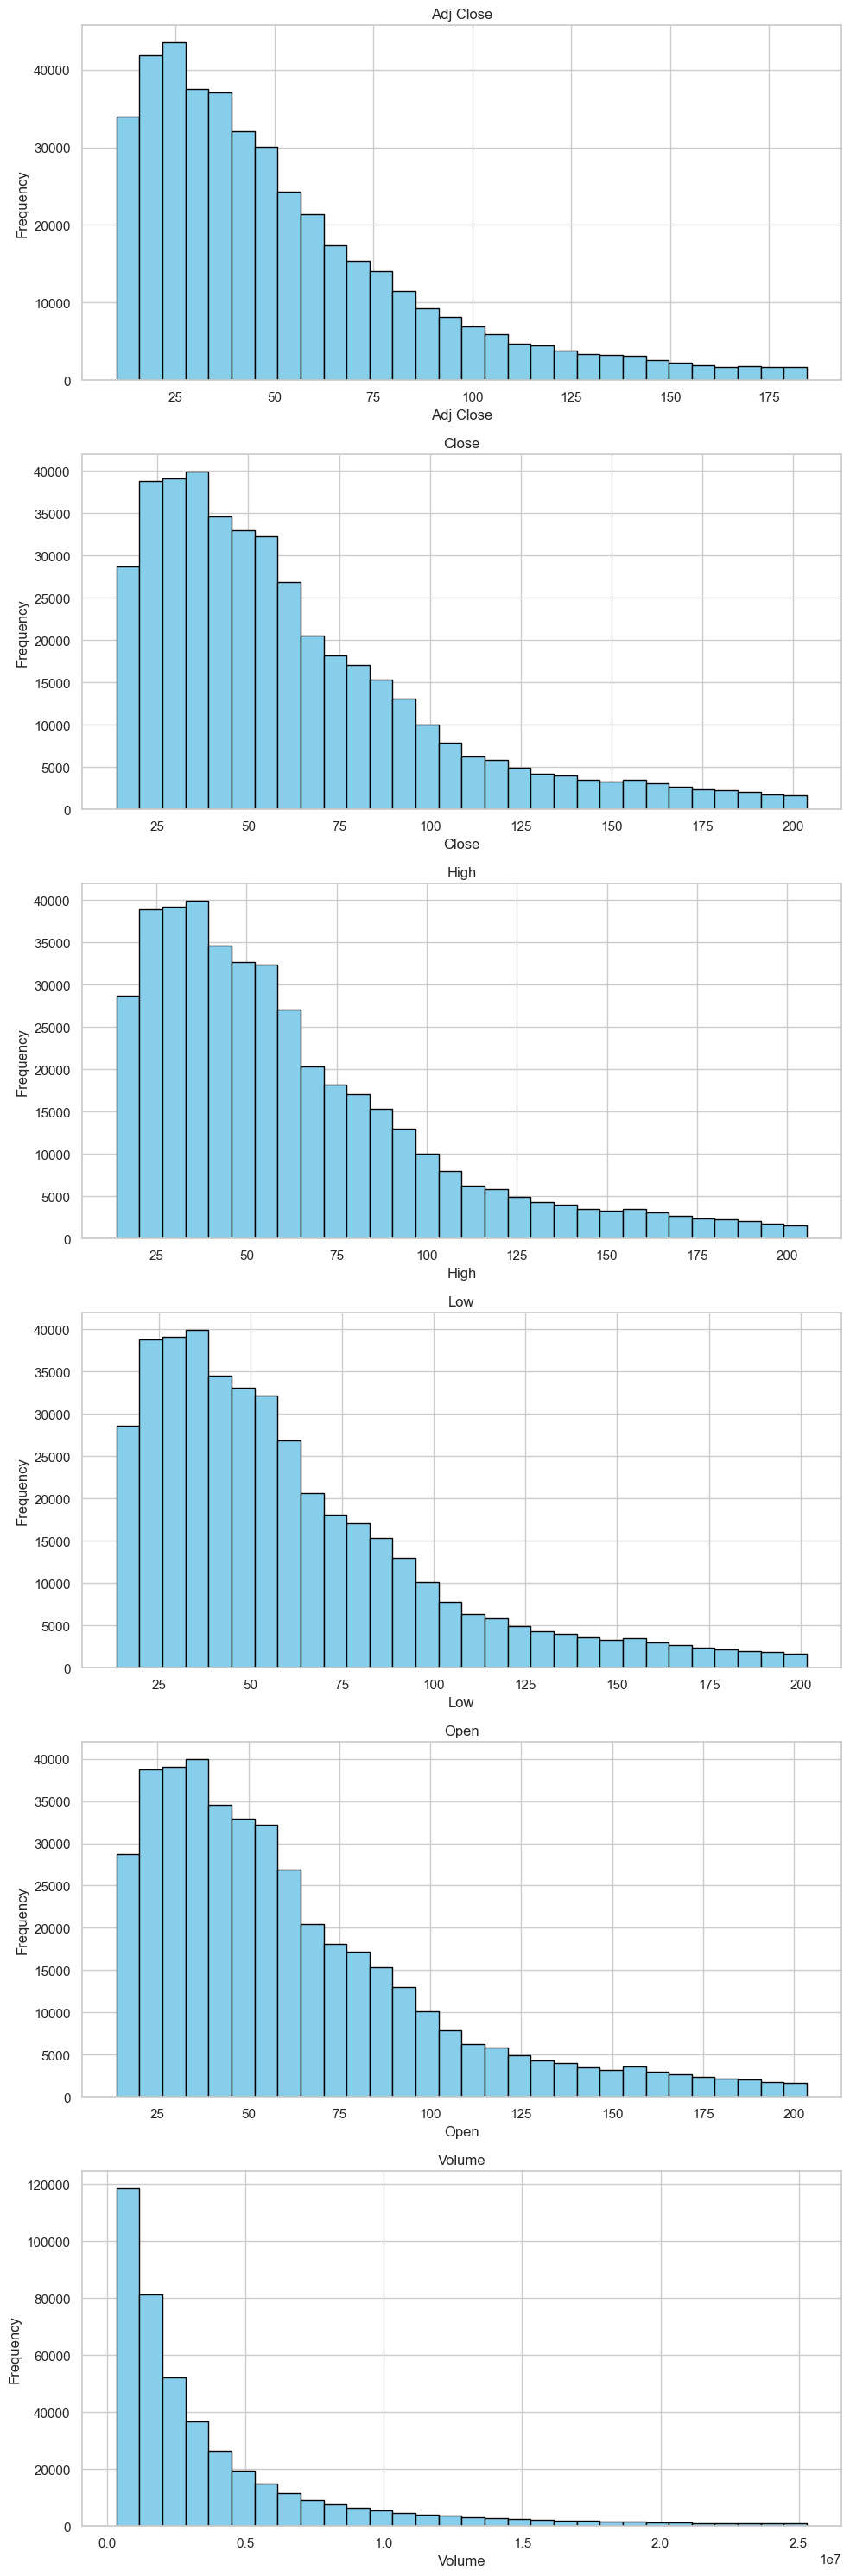

In [181]:
# Kreiranje figure i axes objekata za crtanje više grafikona
fig, axes = plt.subplots(len(features), figsize=(10, 5 * len(features)))

# Pronalaženje 1st i 99th percentila za svaku značajku za ograničenje raspona histograma
percentiles = data_train[features].quantile([0.05, 0.95]).to_dict()

# Generiranje histograma za svaku financijsku značajku unutar definiranog raspona
for i, feature in enumerate(features):
    ax = axes[i]
    feature_range = (percentiles[feature][0.05], percentiles[feature][0.95])
    
    ax.hist(data_train[feature].dropna(), bins=30, range=feature_range, color='skyblue', edgecolor='black')
    ax.set_title(f'{feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

6. Vizualizacija po dionicama


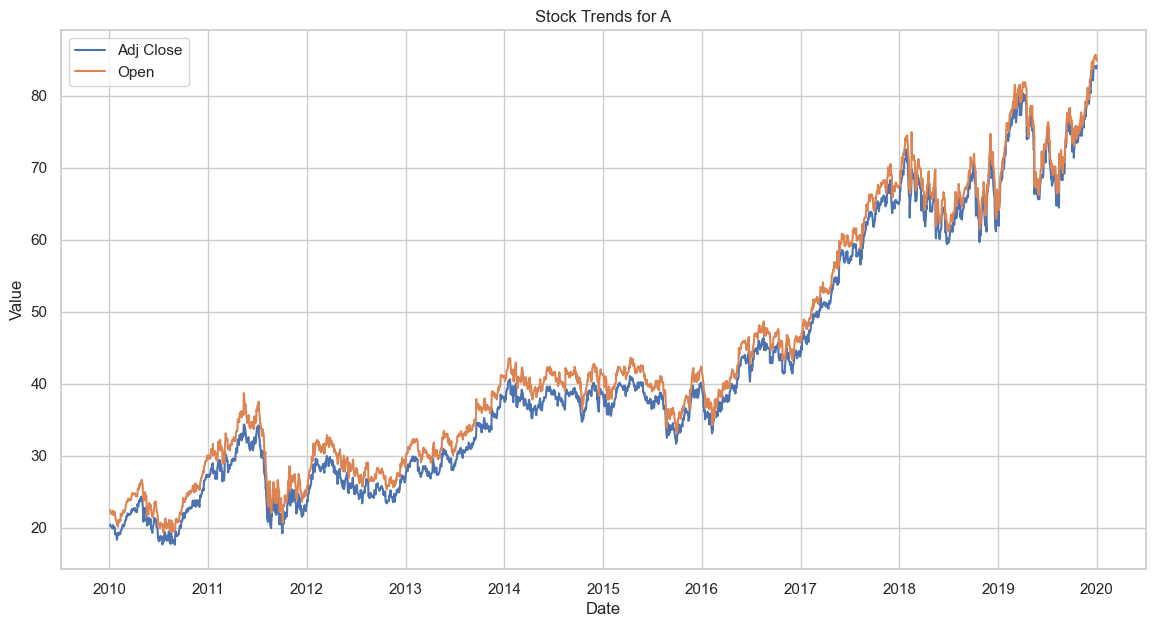

In [182]:
def plot_stock_trends(stock_data, symbol, features, ax=None):
    stock_specific_data = stock_data.loc[stock_data['Symbol'] == symbol].copy()
    stock_specific_data['Date'] = pd.to_datetime(stock_specific_data['Date'])
    
    # Create a new figure and axis object if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot each feature on the y-axis
    for feature in features:
        ax.plot(stock_specific_data['Date'], stock_specific_data[feature], label=feature)
    
    # Formatting the plot
    ax.set_title(f'Stock Trends for {symbol}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    
    return ax

plot_stock_trends(data_train, symbol='A', features=['Adj Close', 'Open'])
plt.show()

7. Koju dionicu je najbolje kupiti na dan 15.4.2017?

Pretpostavljam da ćemo prodati dionice na dan kada je globalni high najveci nakon tog datuma. Najbolja dionica je ona kojoj je omjer prodajna cijena / nabavna cijena najveći. Također nemamo podatke za 14. i 15. u mjesecu jer je bio vikend. Uzimamo vrijednosti 13.4.2017

In [183]:
data_train['Date'] = pd.to_datetime(data_train['Date'])

# Filtriranje podataka za 13.4.2017.
data_13_04_2017 = data_train[data_train['Date'] == '2017-04-13']

data_after_13_04_2017 = data_train[data_train['Date'] > '2017-04-13']

# new dataframe with columns : symbol, data_13_04_2017.low, data_after_13_04_2017.high.max(), ratio
data_13_04_2017_low = data_13_04_2017[['Symbol', 'Low']]
data_after_13_04_2017_high = data_after_13_04_2017.groupby('Symbol')['High'].max().reset_index()
data_after_13_04_2017_high.columns = ['Symbol', 'High']
ratio = data_after_13_04_2017_high['High'] / data_13_04_2017_low['Low']

#merge into 1 dataframe and sort by ratio
data_merged = pd.merge(data_13_04_2017_low, data_after_13_04_2017_high, on='Symbol')
data_merged['Ratio'] = data_merged['High'] / data_merged['Low']

data_merged.sort_values(by='Ratio', ascending=False, inplace=True)
# print(data_merged.head())

print("Najbolja dionica za kupnju je: ", data_merged.iloc[0]['Symbol'])







Najbolja dionica za kupnju je:  ENPH


In [184]:
# #8. 
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.impute import SimpleImputer


# # Priprema značajki i ciljne varijable
# X = data_train[].copy()
# X = X.drop(columns=['target'])  
# y = data_train['target']  # Ciljna varijabla

# # Zamjena nedostajućih vrijednosti srednjom vrijednošću
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# # Podjela podataka na skup za treniranje i skup za testiranje
# X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# # Treniranje osnovnog modela klasifikacije (logistička regresija)
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train, y_train)

# # Evaluacija modela
# y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")


In [185]:
X = data_train.copy().drop(columns=['Target', 'Date', 'Symbol', 'Id'])
y = data_train.copy()['Target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_val_pred = log_reg.predict(X_val)

# Evaluacija modela
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

data_test_interpolated = data_test.copy().drop(columns=['Date', 'Symbol', 'Id'])
data_test_interpolated = data_test_interpolated.interpolate(method='linear', limit_direction='forward', axis=0)

# Priprema testnog skupa (X_test) slično kao X bez 'Id', 'Date', i 'Symbol'
X_test = data_test_interpolated

# Stvaranje predikcija za testni skup
y_test_pred = log_reg.predict(X_test)

# Priprema CSV datoteke za Kaggle
submission = pd.DataFrame({'Id': data_test['Id'], 'Target': y_test_pred})
submission.to_csv('submission.csv', index=False)


Accuracy: 0.7831520993956524
